In [1]:
#Importation des librairies nécessaires
import os
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import Sequential, datasets, layers, models
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.applications import InceptionResNetV2, MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
#from scikeras.wrappers import KerasClassifier

#from keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from keras.utils import to_categorical
from sklearn.model_selection import GridSearchCV

from time import time
from timeit import default_timer as timer

In [2]:
#Vérification que la version GPU de TensorFlow est bien activée et que le GPU est trouvé
tf.config.list_physical_devices('GPU')

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6840093008462268481
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14053015552
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3259466970184689575
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4090 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9"
xla_global_id: 416903419
]


In [4]:
#Chargement du dataframe créé pour le dataset New Plant Disease
%store -r df_NPD

In [5]:
df_NPD.head()

,Categorie,Plante,Maladie,Saine,Suffixe,Abrev,AbrevMaladie,Rotation,Luminosite,Symetrie,...,Mode,Profondeur de couleur,Moyenne R,Moyenne G,Moyenne B,Taille du fichier,Set,DirPath,FileName,FilePath
0,Apple__Apple_scab,Apple,Apple_scab,0,270deg.jpg,FREC,Scab,270,0,0,...,RGB,8,109.957947,129.504242,119.117355,9606,valid,C:\Users\flore\Jupyter\Recog_Plant_Disease\Dat...,00075aa8-d81a-4184-8541-b692b78d398a___FREC_Sc...,C:\Users\flore\Jupyter\Recog_Plant_Disease\Dat...
1,Apple__Apple_scab,Apple,Apple_scab,0,90deg.jpg,FREC,Scab,90,0,0,...,RGB,8,110.123795,129.669220,119.235626,9960,valid,C:\Users\flore\Jupyter\Recog_Plant_Disease\Dat...,00075aa8-d81a-4184-8541-b692b78d398a___FREC_Sc...,C:\Users\flore\Jupyter\Recog_Plant_Disease\Dat...
2,Apple__Apple_scab,Apple,Apple_scab,0,new30degfliplr.jpg,FREC,Scab,30,0,LR,...,RGB,8,89.325546,109.759598,95.272110,10299,valid,C:\Users\flore\Jupyter\Recog_Plant_Disease\Dat...,00075aa8-d81a-4184-8541-b692b78d398a___FREC_Sc...,C:\Users\flore\Jupyter\Recog_Plant_Disease\Dat...
3,Apple__Apple_scab,Apple,Apple_scab,0,270deg.jpg,FREC,Scab,270,0,0,...,RGB,8,92.044342,125.152634,115.290207,11986,valid,C:\Users\flore\Jupyter\Recog_Plant_Disease\Dat...,01f3deaa-6143-4b6c-9c22-620a46d8be04___FREC_Sc...,C:\Users\flore\Jupyter\Recog_Plant_Disease\Dat...
4,Apple__Apple_scab,Apple,Apple_scab,0,90deg.jpg,FREC,Scab,90,0,0,...,RGB,8,129.272934,125.058243,113.740295,20194,valid,C:\Users\flore\Jupyter\Recog_Plant_Disease\Dat...,0208f4eb-45a4-4399-904e-989ac2c6257c___FREC_Sc...,C:\Users\flore\Jupyter\Recog_Plant_Disease\Dat...


In [6]:
#Récupération des données des set train et valid dans 2 nouveaux dataframes
train_data = df_NPD[df_NPD["Set"] == "train"]
valid_data = df_NPD[df_NPD["Set"] == "valid"]

#Vérification de la répartition des classes
train_counts = train_data["Saine"].value_counts()
valid_counts = valid_data["Saine"].value_counts()

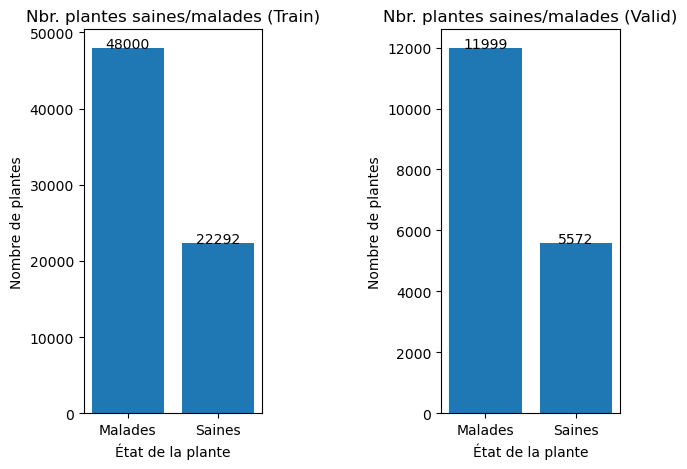

In [7]:
#Graphique pour l'ensemble de validation
plt.subplot(1, 2, 1)
plt.bar(["Malades", "Saines"], train_counts)
plt.xlabel("État de la plante")
plt.ylabel("Nombre de plantes")
plt.title("Nbr. plantes saines/malades (Train)")
plt.text(0, train_counts[0], str(train_counts[0]), ha='center')
plt.text(1, train_counts[1], str(train_counts[1]), ha='center')

#Graphique pour l'ensemble d'entraînement
plt.subplot(1, 2, 2)
plt.bar(["Malades", "Saines"], valid_counts)
plt.xlabel("État de la plante")
plt.ylabel("Nombre de plantes")
plt.title("Nbr. plantes saines/malades (Valid)")
plt.text(0, valid_counts[0], str(valid_counts[0]), ha='center')
plt.text(1, valid_counts[1], str(valid_counts[1]), ha='center')

plt.tight_layout()
plt.subplots_adjust(wspace=1)
plt.show()

In [8]:
print("Pourcentage plantes saines (Train) : ", round((train_counts[1]*100)/train_counts.sum(),2), "%", sep='')
print("Pourcentage plantes malades (Train) : ", round((train_counts[0]*100)/train_counts.sum(),2), "%", sep='')
print("---------------------------------------------")
print("Pourcentage plantes saines (Valid) : ", round((valid_counts[1]*100)/valid_counts.sum(),2), "%", sep='')
print("Pourcentage plantes malades (Valid) : ", round((valid_counts[0]*100)/valid_counts.sum(),2), "%", sep='')

Pourcentage plantes saines (Train) : 31.71%
Pourcentage plantes malades (Train) : 68.29%
---------------------------------------------
Pourcentage plantes saines (Valid) : 31.71%
Pourcentage plantes malades (Valid) : 68.29%


In [9]:
#Remplacement des 0 et des 1 par une chaîne de caractères
train_data["Saine"] = train_data["Saine"].map({0: "Malade", 1: "Saine"})
valid_data["Saine"] = valid_data["Saine"].map({0: "Malade", 1: "Saine"})

C:\Users\flore\AppData\Local\Temp\ipykernel_37904\1419961183.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data["Saine"] = train_data["Saine"].map({0: "Malade", 1: "Saine"})
C:\Users\flore\AppData\Local\Temp\ipykernel_37904\1419961183.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data["Saine"] = valid_data["Saine"].map({0: "Malade", 1: "Saine"})


In [10]:
#Création des générateurs d'image pour train et valid
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, rescale=1./255)

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, rescale=1./255)

In [11]:
#Création des dataset d'entrainement et de validation
print("Création du set d'entraînement avec le générateur d'image :")
training_set = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=None,   #None car nous utilisons "FilePath" du dataframe pour charger les images
    x_col='FilePath',   #Colonne contenant les chemins des fichiers
    y_col='Saine',   #Colonne contenant les étiquettes (0 pour malade, 1 pour sain)
    target_size=(128, 128),
    class_mode="categorical",
    batch_size=64,
    shuffle=True,
    seed=111
)

print("\nCréation du set de validation avec le générateur d'image :")
valid_set = valid_datagen.flow_from_dataframe(
    dataframe=valid_data,
    directory=None,   #None car nous utilisons "FilePath" du dataframe pour charger les images
    x_col='FilePath',   #Colonne contenant les chemins des fichiers
    y_col='Saine',   #Colonne contenant les étiquettes (0 pour malade, 1 pour sain)
    target_size=(128, 128),
    class_mode="categorical",
    batch_size=64,
    shuffle=False
)

Création du set d'entraînement avec le générateur d'image :
Found 70292 validated image filenames belonging to 2 classes.

Création du set de validation avec le générateur d'image :
Found 17571 validated image filenames belonging to 2 classes.


In [12]:
#Chargement du modèle MobileNetV2 pré-entraîné avec poids sur ImageNet
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

#Freeze des poids des couches de base du modèle pré-entraîné
for layer in base_model.layers:
    layer.trainable = False

#Création du modèle basé sur MobileNetV2
classifier = Sequential()

classifier.add(base_model)
classifier.add(GlobalAveragePooling2D())
classifier.add(Dense(256, activation='relu', kernel_initializer="glorot_uniform"))
classifier.add(Dropout(rate=0.2))
classifier.add(Dense(128, activation='relu', kernel_initializer="glorot_uniform"))
classifier.add(Dropout(rate=0.2))
classifier.add(Dense(2, activation='softmax', kernel_initializer="glorot_uniform"))

#Résumé du modèle
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0

In [13]:
#Initialisation de différents Callback pour les tests
class TimingCallback(Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)
        
        
def schedule(epoch):
    if epoch < 5:
        return 1e-4
    else:
        return 1e-5

    
time_callback = TimingCallback()

learn_rate_schd = LearningRateScheduler(schedule, verbose = 0)

early_stopping = EarlyStopping(patience=5, min_delta = 0.01, mode = 'min', 
                               monitor='val_loss', verbose=1)

reduce_learning_rate = ReduceLROnPlateau(monitor="val_loss", patience=3, min_delta= 0.01, 
                                         factor=0.1, cooldown = 4, verbose=1)

In [14]:
#Compilation et entraînement du modèle créé
batch_size = 64
epochs = 20
learning_rate = 1e-3

classifier.compile(optimizer=Adam(learning_rate=learning_rate), 
                   loss='categorical_crossentropy', metrics=['accuracy'])

history = classifier.fit(x=training_set, epochs = epochs, 
                         steps_per_epoch = training_set.samples // batch_size, 
                         validation_data=valid_set, 
                         validation_steps=valid_set.samples // batch_size,
                         callbacks = [time_callback, reduce_learning_rate, early_stopping],
                         workers = -1,
                         verbose = True)

Epoch 1/20
1098/1098 [==============================] - 154s 136ms/step - loss: 0.6302 - accuracy: 0.6815 - val_loss: 0.6237 - val_accuracy: 0.6823 - lr: 0.0010
Epoch 2/20
1098/1098 [==============================] - 120s 109ms/step - loss: 0.6245 - accuracy: 0.6829 - val_loss: 0.6305 - val_accuracy: 0.6823 - lr: 0.0010
Epoch 3/20
1098/1098 [==============================] - 105s 96ms/step - loss: 0.6222 - accuracy: 0.6829 - val_loss: 0.6225 - val_accuracy: 0.6823 - lr: 0.0010
Epoch 4/20
1098/1098 [==============================] - ETA: 0s - loss: 0.6192 - accuracy: 0.6829
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
1098/1098 [==============================] - 105s 96ms/step - loss: 0.6192 - accuracy: 0.6829 - val_loss: 0.6176 - val_accuracy: 0.6823 - lr: 0.0010
Epoch 5/20
1098/1098 [==============================] - 105s 96ms/step - loss: 0.6137 - accuracy: 0.6828 - val_loss: 0.6143 - val_accuracy: 0.6823 - lr: 1.0000e-04
Epoch 6/20
1098/1098 [========

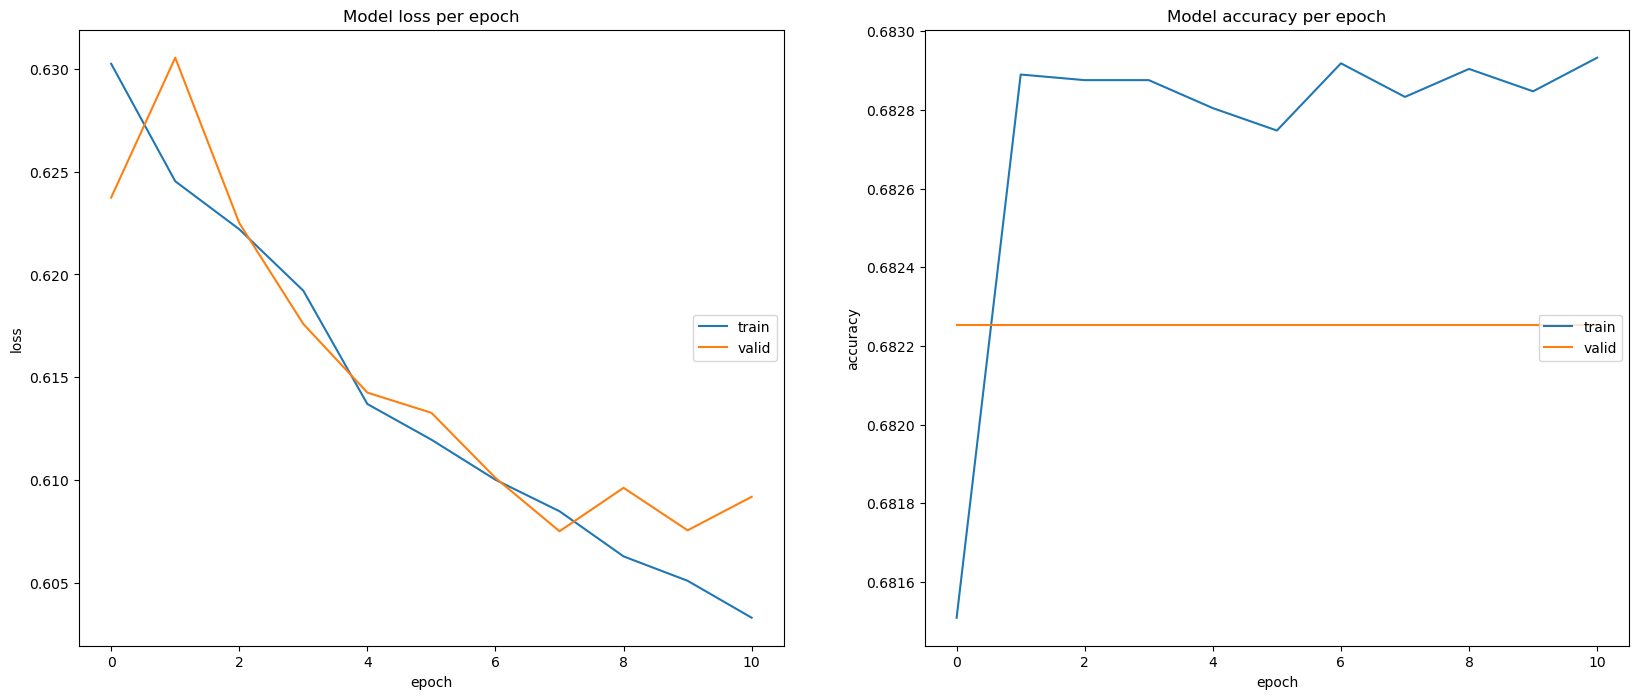

In [15]:
#Vérification de la précision et de la perte lors de l'entraînement
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

#Affichage des graphiques liés à l'entraînement
plt.figure(figsize = (20, 8))

plt.subplot(121)
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Model loss per epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')

plt.subplot(122)
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('Model accuracy per epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')

plt.show()

1/1 [==============================] - 0s 411ms/step


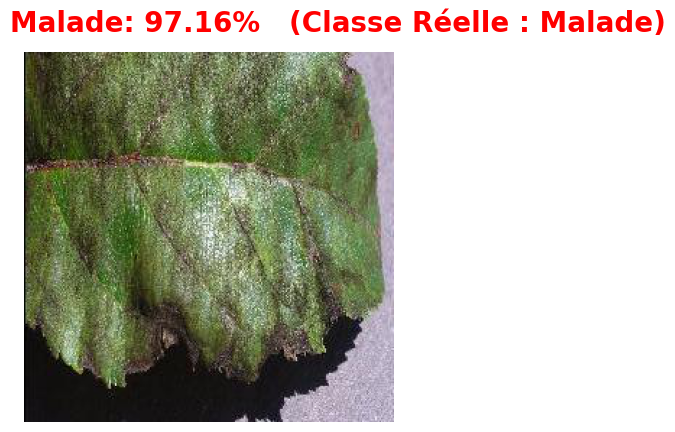

1/1 [==============================] - 0s 19ms/step


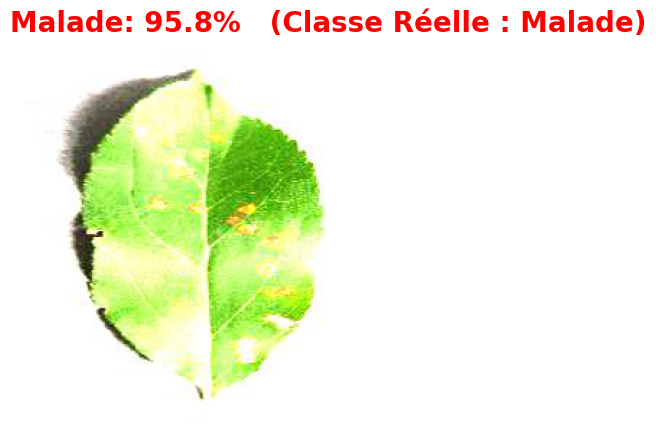

1/1 [==============================] - 0s 16ms/step


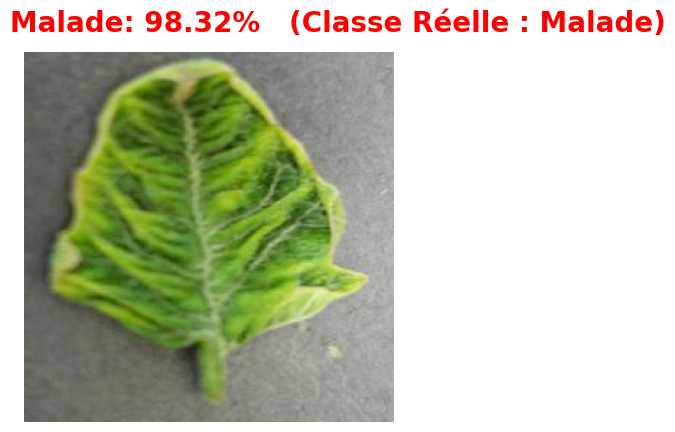

1/1 [==============================] - 0s 17ms/step


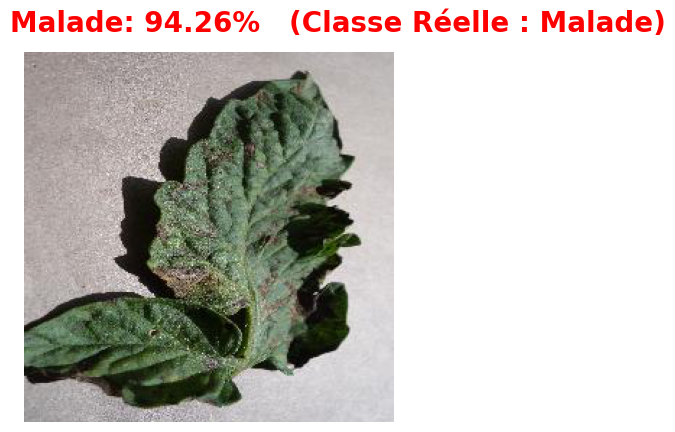

1/1 [==============================] - 0s 15ms/step


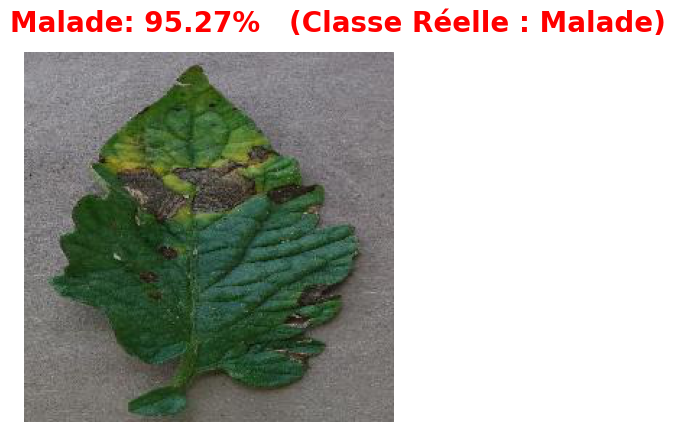

1/1 [==============================] - 0s 20ms/step


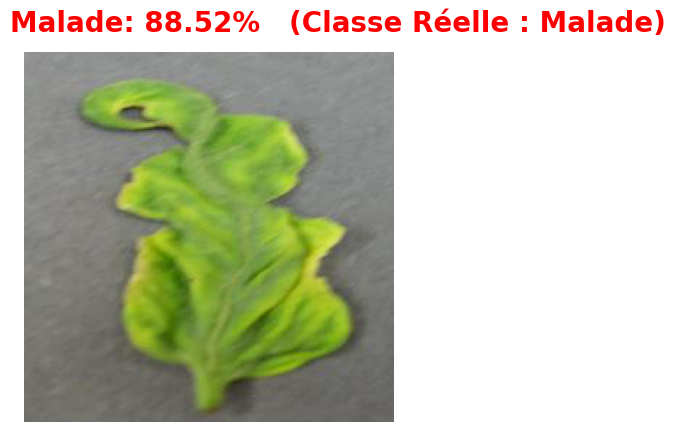

1/1 [==============================] - 0s 8ms/step


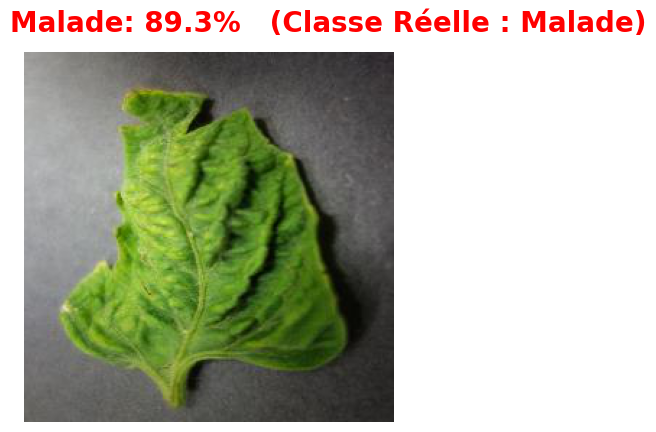

1/1 [==============================] - 0s 16ms/step


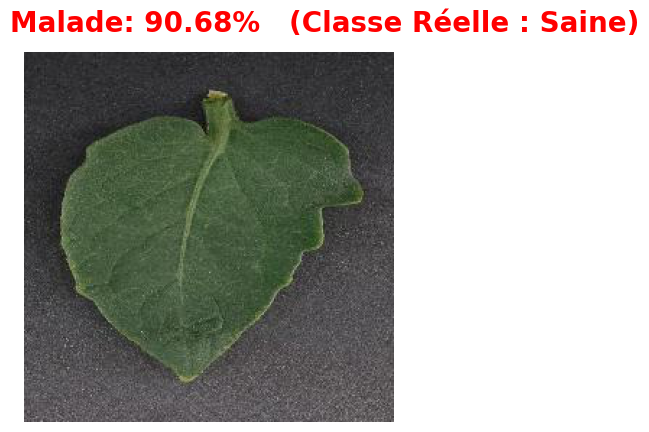

1/1 [==============================] - 0s 16ms/step


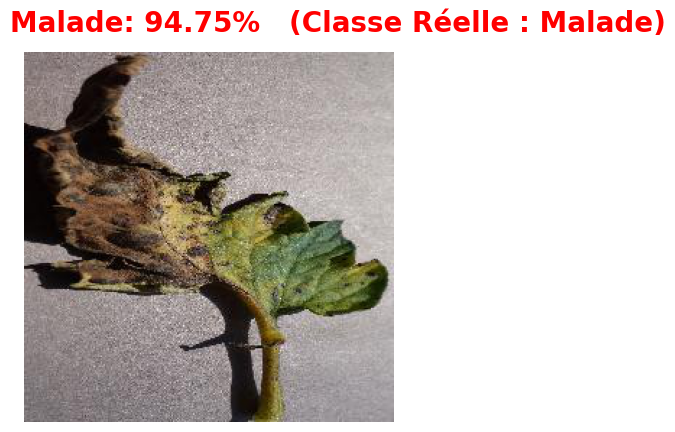

1/1 [==============================] - 0s 16ms/step


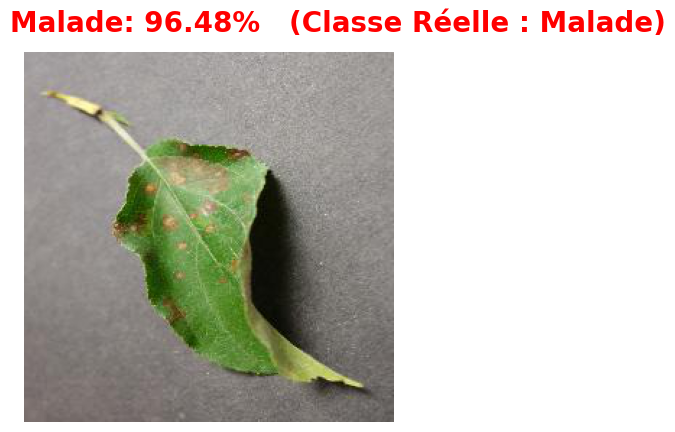

In [16]:
#Vérification du modèle entrainé sur images de test

#Chemin du répertoire contenant les images
test_dir = r"C:\Users\flore\Jupyter\Recog_Plant_Disease\Datasets\NPD\test\Test___Pictures_Random"

#Obtention de la liste des noms de fichiers d'images
file_list = os.listdir(test_dir)

#Sélection aléatoire de 10 fichiers d'images
selected_files = random.sample(file_list, 10)

#Boucle pour afficher les images
for file in selected_files:
    file_path = os.path.join(test_dir, file)
    
    #Récupération de la classe réelle (via le nom du fichier)
    if "Healthy" in file:
        real_class = 'Saine'
    else:
        real_class = 'Malade'
    
    #Chargement et prétraitement de l'image
    test_image = image.load_img(file_path, target_size=(128, 128))
    test_image = image.img_to_array(test_image) / 255
    test_image = np.expand_dims(test_image, axis=0)
    
    #Prédiction de la classe
    proba = round(100 * classifier.predict(test_image)[0][1], 2)
    if proba < 50:
        plant_state = 'Malade'
        proba = round(100 - proba, 2)
    else:
        plant_state = 'Saine'
    
    #Chargement et affichage de l'image
    img = mpimg.imread(file_path)
    plt.axis('off')
    plt.text(-10, -15, plant_state + ': ' + str(proba) + '%' + '   (Classe Réelle : ' + real_class + ')', color=(1, 0, 0), fontsize=20, fontweight='extra bold')
    imgplot = plt.imshow(img)
    plt.show()